In [1]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchaudio
import numpy as npw
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, SequentialSampler
from sklearn.model_selection import train_test_split
from adasp_data_management import music

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-6

/home/ids/edabier/miniconda3/envs/amt-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
    torch.set_default_device(dev)
else:
    print(f"{torch.cuda.is_available()}")
    dev = "cpu"

In [3]:
path = "/home/ids/edabier/AMT/Unrolled-NMF/MAPS/metadata.csv"
metadata = pd.read_csv(path)

split=0.8
length=10
batch=4
subset=0.1
num_workers=1
n_iter=10
shared=True
aw2d=False
clip=True
lr=1e-5
epochs=2
dtype = None#torch.float16
    
# Set the multiprocessing start method
torch.multiprocessing.set_start_method('spawn', force=True)

train_data, test_data   = train_test_split(metadata, train_size=split, random_state=1)
train_data, valid_data  = train_test_split(train_data, train_size=split, random_state=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

train_set   = utils.LocalMapsDataset(train_data, fixed_length=length, subset=subset, verbose=False, dtype=dtype)
valid_set   = utils.LocalMapsDataset(valid_data, fixed_length=length, subset=subset, verbose=False, dtype=dtype)

train_sampler   = utils.SequentialBatchSampler(train_set, batch_size=batch)
train_loader    = DataLoader(train_set, batch_sampler=train_sampler, collate_fn=utils.collate_fn, num_workers=num_workers)

valid_sampler   = utils.SequentialBatchSampler(valid_set, batch_size=batch)
valid_loader    = DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=utils.collate_fn, num_workers=num_workers)

W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=n_iter, n_init_steps=1, shared=shared, return_layers=False, aw_2d=aw2d, clip_H=clip, dtype=dtype)
ralmu = ralmu.to(dev)

W0, _, _, _ = init.init_W(ralmu.W_path, downsample=ralmu.downsample, normalize_thresh=ralmu.norm_thresh, eps=ralmu.eps, verbose=ralmu.verbose, dtype=ralmu.dtype)

optimizer   = torch.optim.AdamW(ralmu.parameters(), lr=lr)
criterion   = nn.MSELoss()

0it [00:00, ?it/s]

16it [00:00, 19.25it/s]
/home/ids/edabier/AMT/Unrolled-NMF/src/utils.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.metadata.loc[:,'segment_indices'] = self.compute_length()
4it [00:00, 69.07it/s]
/home/ids/edabier/AMT/Unrolled-NMF/src/utils.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.metadata.loc[:,'segment_indices'] = self.compute_length()


In [4]:
losses, valid_losses, W_hat, H_hat = utils.train(ralmu, train_loader, valid_loader, optimizer, criterion, dev, epochs, W0=W0, use_wandb=False)

epoch 0, loss = 0.096151
validation loss decreased (inf --> 175.833289).  Saving model ...
epoch 1, loss = 0.068381


In [5]:
base_dir = path

# Define the directories
m_dir = os.path.join(base_dir, 'M')
midi_dir = os.path.join(base_dir, 'H', 'midi')
onsets_dir = os.path.join(base_dir, 'H', 'onsets')
offsets_dir = os.path.join(base_dir, 'H', 'offsets')

# Get the list of files in the M directory
m_files = sorted(os.listdir(m_dir))

# Initialize a list to store the metadata
metadata = []
for m_file in m_files:
    # Extract the base name without extension
    base_name = os.path.splitext(m_file)[0]

    # Define the corresponding file paths
    file_path = os.path.join(m_dir, m_file)
    midi_path = os.path.join(midi_dir, f"{base_name}.pt")
    onset_path = os.path.join(onsets_dir, f"{base_name}.pt")
    offset_path = os.path.join(offsets_dir, f"{base_name}.pt")

    # Add the file paths to the metadata list
    metadata.append({
        "file_path": file_path,
        "midi_path": midi_path,
        "onset_path": onset_path,
        "offset_path": offset_path
    })

# Create a DataFrame from the metadata list
metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv(f'{path}/metadata.csv', index=False)

NotADirectoryError: [Errno 20] Not a directory: '/home/ids/edabier/AMT/Unrolled-NMF/MAPS/metadata.csv/M'

In [ ]:
import csv
filename='logs/gpu_info_log.csv'
with open(filename, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["time", "partition_name", "power_usage", "memory_usage"])

In [ ]:
import os

def get_folder_size_in_gb(folder_path):
    total_size = 0

    # Walk through all the directories and files in the folder
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            # Get the full file path
            file_path = os.path.join(dirpath, filename)

            # Add the size of the file to the total size
            total_size += os.path.getsize(file_path)

    # Convert the total size from bytes to gigabytes
    total_size_gb = total_size / (1024 ** 3)

    return total_size_gb

size_M = get_folder_size_in_gb("MAPS/M")
size_H = get_folder_size_in_gb("MAPS/H")
total_size = size_M + size_H
print(f'The size of the folder is {total_size:.2f} GB')

The size of the folder is 116.08 GB


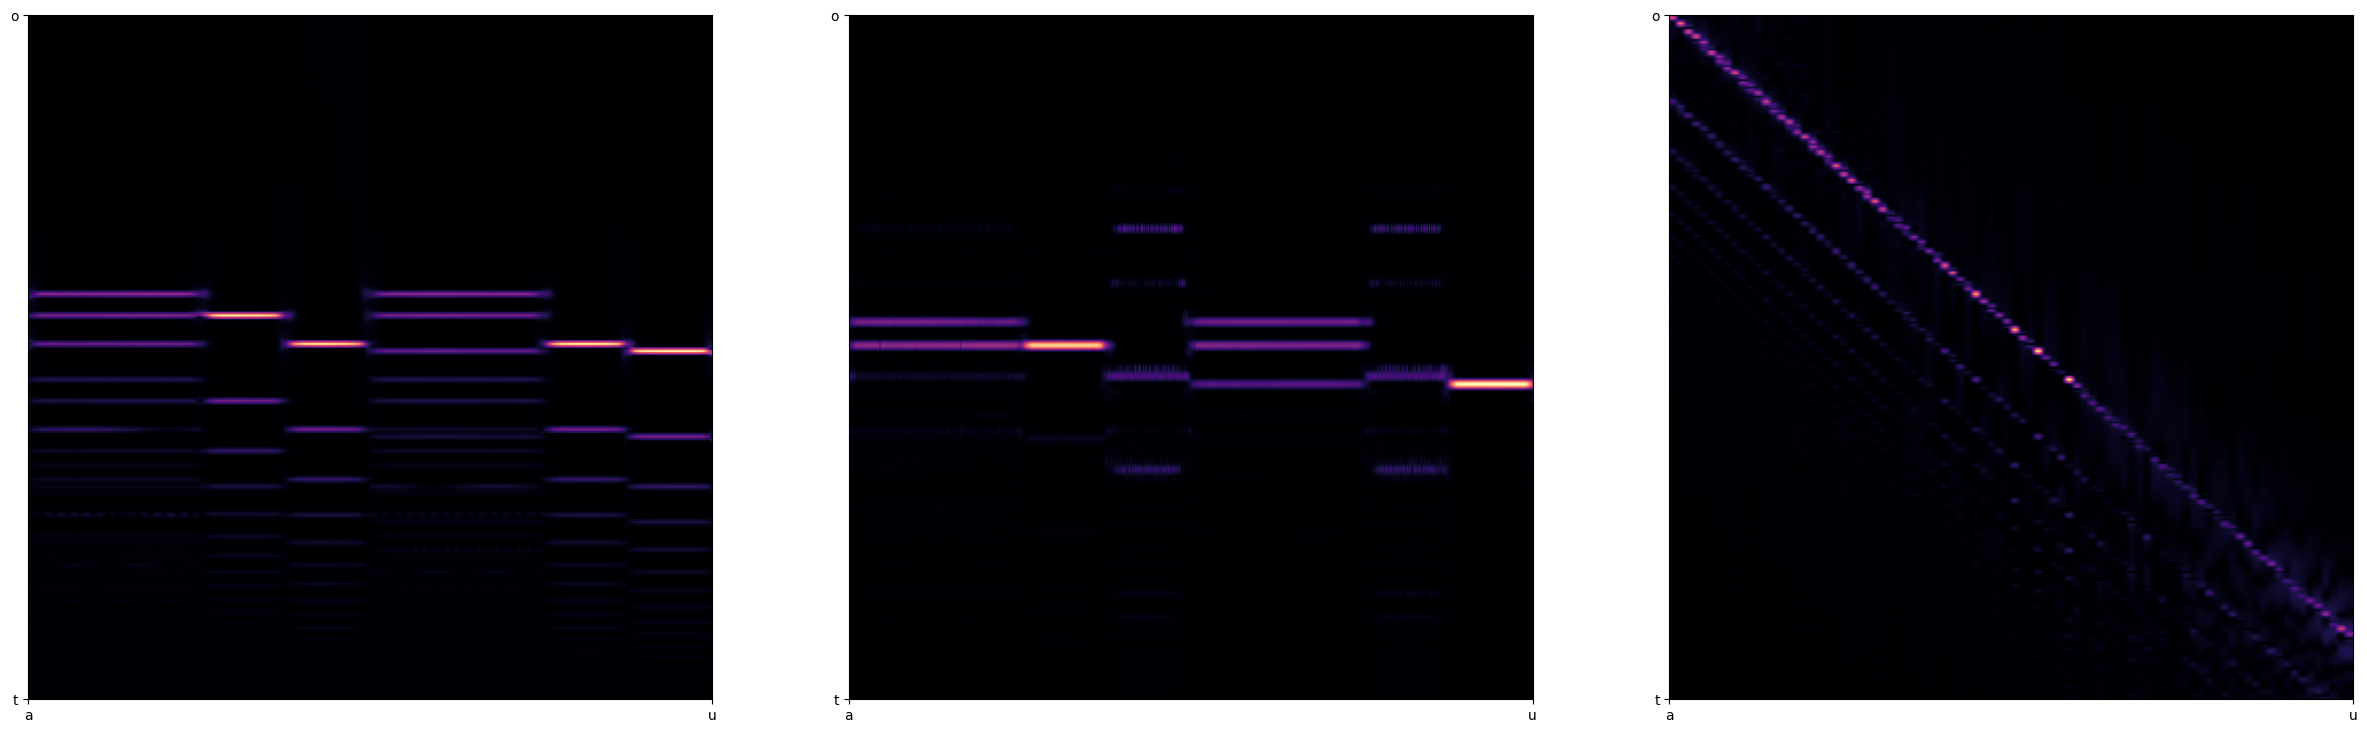

In [ ]:
y, sr = torchaudio.load("synth-dataset/audios/example-1.wav")
M, times, freqs_M = spec.cqt_spec(y, sr, normalize_thresh=0.1, dtype=torch.float16)
single_note = 'test-data/synth-single-notes'
W, freqs, sample_rate, true_freqs = init.init_W(single_note, normalize=True, dtype=torch.float16)
H = init.init_H(l=88, t=M.shape[1], W=W, M=M, n_init_steps=10, device=dev, dtype=torch.float16)

# for i, freq in enumerate(freqs_M):
#     freqs_M[i] = freq.cpu()

fig, axs = plt.subplots(1,3, figsize=(30,10))

axs[0].imshow(M.cpu(), extent="auto", cmap="magma")
axs[1].imshow(H.cpu(), extent="auto", cmap="magma")
axs[2].imshow(W.cpu(), extent="auto", cmap="magma")

# spec.vis_cqt_spectrogram(H.cpu(), times, freqs_M, 0, times[-1])
# octave_W = [W[:, :4]] + [W[:, i+4:i+16] for i in range(0, 84, 12)]

### Load the ground truth dataset

In [ ]:
# maps = music.Maps("/tsi/mir/maps")
# metadata = maps.pdf_metadata

# dataset = utils.MapsDataset(metadata, subset=0.001, sort=True, filter=True, fixed_length=10)
# batch_size = 2

# sampler = utils.SequentialBatchSampler(dataset, batch_size)
# data_loader = DataLoader(dataset, batch_sampler=sampler, collate_fn=utils.collate_fn)

In [ ]:
maps = music.Maps("/tsi/mir/maps")
metadata = maps.pdf_metadata

train_size = 0.8
train_data, test_data   = train_test_split(metadata, train_size=train_size, random_state=1)
train_data, valid_data  = train_test_split(train_data, train_size=train_size, random_state=1)

subset = 1
length = None
sort = True
filt = True
dtype = torch.float16

train_set   = utils.MapsDataset(train_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt, dtype=dtype)
test_set    = utils.MapsDataset(test_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt, dtype=dtype)
valid_set   = utils.MapsDataset(valid_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt, dtype=dtype)

batch_size      = 4
train_sampler   = utils.SequentialBatchSampler(train_set, batch_size=batch_size)
train_loader    = DataLoader(train_set, batch_sampler=train_sampler, collate_fn=utils.collate_fn)

test_sampler   = utils.SequentialBatchSampler(test_set, batch_size=batch_size)
test_loader     = DataLoader(test_set, batch_sampler=test_sampler, collate_fn=utils.collate_fn)

valid_sampler   = utils.SequentialBatchSampler(valid_set, batch_size=batch_size)
valid_loader    = DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=utils.collate_fn)

Maps: load metadata file /tsi/mir/maps/metadata.csv
Computing the length of files...


1111it [02:12,  6.68it/s]

In [ ]:
dataset = pd.concat([train_set.metadata, test_set.metadata, valid_set.metadata])

In [ ]:
# maps = music.Maps("/tsi/mir/maps")
# metadata = maps.pdf_metadata
# dataset = utils.MapsDataset(metadata, fixed_length=False, subset=0.01, verbose=True, sort=True, mean_filter=True)

# train_size = 0.8
# batch_size = 2

# sampler = utils.SequentialBatchSampler(dataset, batch_size)
# data_loader = DataLoader(dataset, batch_sampler=sampler, collate_fn=utils.collate_fn)

# # Create DataLoaders for training and validationw
# train_loader = []
# valid_loader = []

# for i, batch in enumerate(data_loader):
#     if i % 5 == 0:  # Every 5th batch goes to validation
#         valid_loader.append(batch)
#     else:
#         train_loader.append(batch)
# print(f"Train dataset: {len(train_loader)}, valid dataset: {len(valid_loader)}")

In [ ]:
# sizes = train_set.metadata.duration
sizes = dataset.duration
mean_size = np.mean(sizes)
std_size = np.std(sizes)

# Histogram with logarithmic scale
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(sizes, bins=100, alpha=0.7, color='blue', log=True)
plt.title('Distribution of File sizes (log)')# in the validation set')
plt.xlabel('Time (s)')
plt.ylabel('Log(Frequency)')
plt.grid(True)

# Box plot
# plt.subplot(1, 2, 2)
# plt.boxplot(sizes, vert=False, patch_artist=True)
# plt.title('Box Plot of File sizes')
# plt.xlabel('Time (s)')
# plt.grid(True)

plt.tight_layout()
plt.show()

### Harmonicity score:

In [ ]:
W_path_synth = 'test-data/synth-single-notes'
W_path_piano = 'test-data/piano-single-notes'
W_synth, _, _, _ = init.init_W(W_path_synth, normalize=True)
W_piano, _, _, _ = init.init_W(W_path_piano, normalize=True)
W_synthetic, _, _, _ = init.init_W(normalize=False)

sigma = 0.01
W_noisy = W_synth + sigma*torch.rand(W_synth.shape)
noise = torch.rand(W_synthetic.shape)

Initialized W with synthetic data


In [ ]:
log_val = 1e-5

harmonicity_synth = torch.mean(utils.spectral_flatness(W_synth, log_val))
harmonicity_piano = torch.mean(utils.spectral_flatness(W_piano, log_val))
harmonicity_synthetic = torch.mean(utils.spectral_flatness(W_synthetic, log_val))
harmonicity_noisy = torch.mean(utils.spectral_flatness(W_noisy, log_val))
harmonicity_noise = torch.mean(utils.spectral_flatness(noise, log_val))
print(f"synth = {harmonicity_synth}, piano = {harmonicity_piano}, synthetic = {harmonicity_synthetic}, noisy = {harmonicity_noisy}, noise = {harmonicity_noise}")

synth = 0.12092094123363495, piano = 0.17047619819641113, synthetic = 0.002997461473569274, noisy = 0.6103235483169556, noise = 0.7398760914802551


### Create the model
`hidden`=`8`, `shared`=`True` => 1122 params

In [ ]:
W_path = 'test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=10, n_init_steps=1, hidden=8, shared=True, return_layers=False, batch_size=batch_size, smaller_A=True, dtype=dtype)
utils.model_infos(ralmu, names=False)
ralmu

The model has 1122 parameters


RALMU(
  (layers): ModuleList(
    (0-9): 10 x RALMU_block(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.

### Train the model

epoch 0, loss =   nan


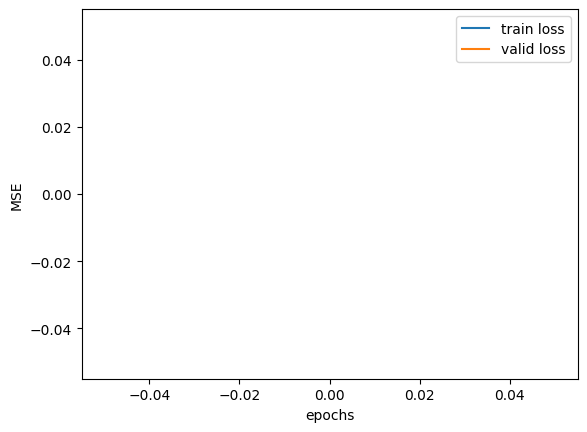

In [ ]:
optimizer   = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)
criterion   = nn.MSELoss()
# device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ralmu = ralmu.to(dev)
epochs      = 1

train1 = False
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)

# losses, W_warmup, H_warmup, H1 = utils.warmup_train(ralmu, n_epochs1, train_loader, optimizer1, device, debug=True)

losses, valid_losses, W_hat, H_hat = utils.train(ralmu, train_loader, valid_loader, optimizer, criterion, dev, epochs)

# spec.vis_cqt_spectrogram(ralmu.W0, np.arange(ralmu.W0.shape[1]), np.arange(ralmu.W0.shape[0]), 0, ralmu.W0.shape[1])
# spec.vis_cqt_spectrogram(W_warmup.detach(), np.arange(W_warmup.shape[1]), np.arange(W_warmup.shape[0]), 0, W_warmup.shape[1])
# spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1])

plt.plot(losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.ylabel("MSE")
plt.xlabel("epochs")
plt.legend()

In [6]:
dataset_name = "piano-dataset"
W_path = 'test-data/synth-single-notes'
y, sr = torchaudio.load(f"{dataset_name}/audios/example-6.wav")
y = y.to(dev)

M, times, _ = spec.cqt_spec(y, sr, hop_length=128)
M = M.to(dev)

midi, onset, offset, _ = spec.midi_to_pianoroll(f"{dataset_name}/midis/example-6.mid", y, times,128,sr)
midi = midi.to(dev)
active_midi = [i for i in range(88) if (midi[i, :] > 0).any().item()]
H = init.MIDI_to_H(midi, active_midi, onset, offset)
H = H.to(dev)
W, _, _, _ = init.init_W(W_path)
W = W.to(dev)

In [10]:
model_path = 'models/RALMU.pt'
weights = torch.load(model_path)
# weights.pop("H0")
batch_size = 2
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=5, n_init_steps=1, hidden=8, shared=True, return_layers=False)

# ralmu.load_state_dict(weights)
# ralmu.init_H(M)
ralmu.eval()
W_hat, H_hat, M_hat, _ = ralmu.forward(M, device=dev)
M_hat = M_hat.detach()

In [11]:
print(utils.compute_metrics(H_hat, H, threshold=1))

(0, 0, 0, 0)


NameError: name 'pos' is not defined

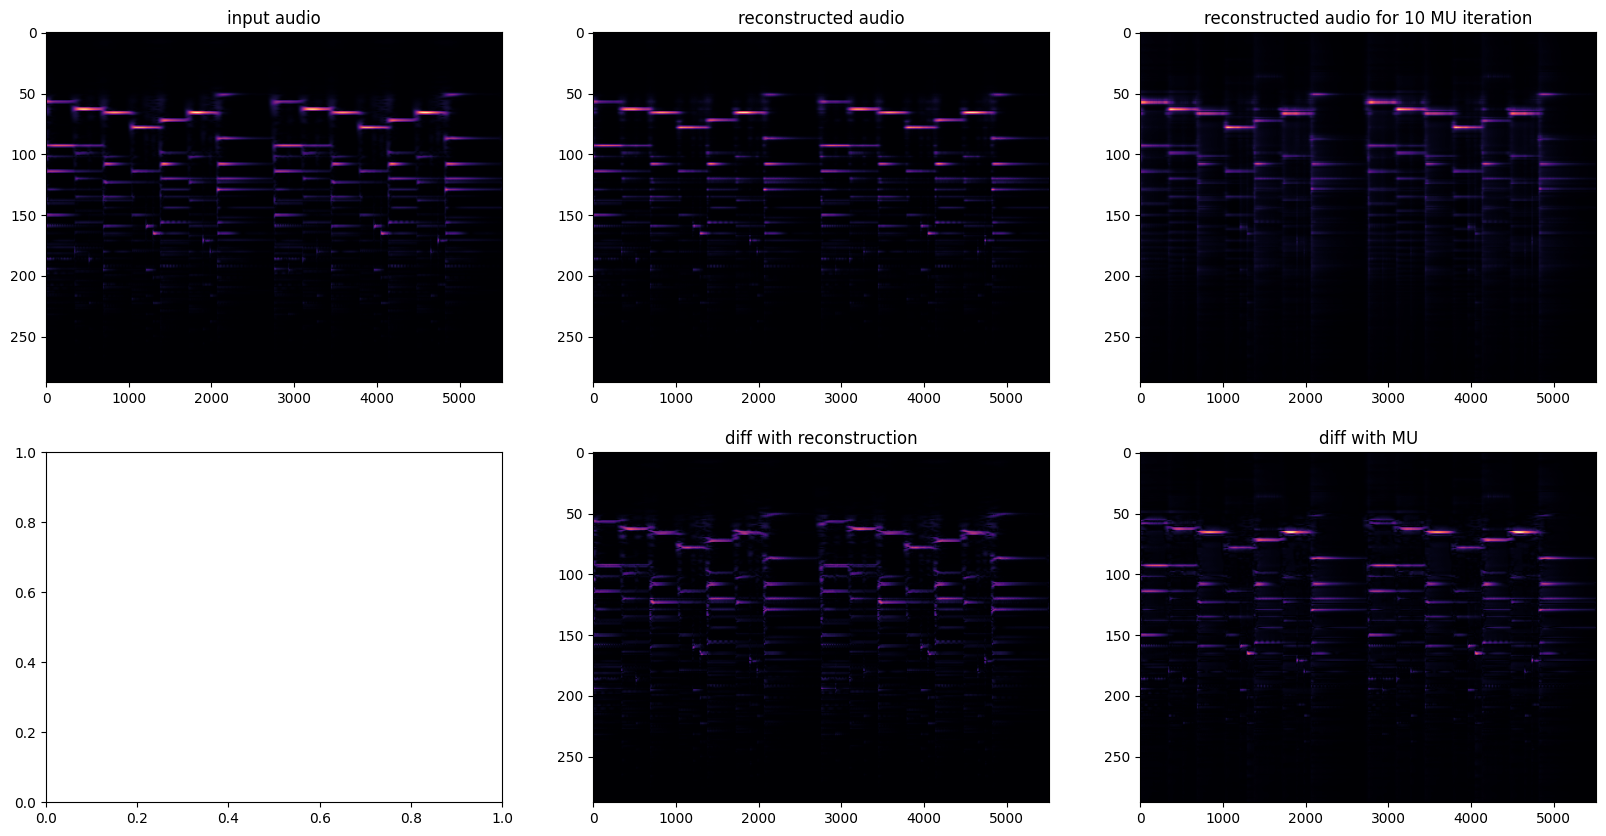

In [ ]:
# M_n = np.apply_along_axis(lambda x: x / np.sum(np.abs(x)), axis=0, arr=M)
# M_hat_n = np.apply_along_axis(lambda x: x / np.sum(np.abs(x)), axis=0, arr=M_hat.detach())
import numpy as np
n_steps = 10
H_mu = init.init_H(l=88, t=M.shape[1], W=torch.tensor(W), M=M, n_init_steps=n_steps)
M_mu = W @ H_mu

diff = np.abs(M.cpu() - M_hat.detach().cpu())
diff_r = np.abs(M.cpu() - M_mu.cpu())
fig, ax = plt.subplots(2, 3, figsize=(20,10))
ax[0, 0].imshow(M.cpu(), aspect="auto", cmap='magma')
ax[0, 0].set_title("input audio")

ax[0, 1].imshow(M_hat.cpu(),  aspect="auto", cmap='magma')
ax[0, 1].set_title("reconstructed audio")

ax[0, 2].imshow(M_mu.cpu(),  aspect="auto", cmap='magma')
ax[0, 2].set_title(f"reconstructed audio for {n_steps} MU iteration")

ax[1, 1].imshow(diff, aspect="auto", cmap='magma')
ax[1, 1].set_title("diff with reconstruction")

ax[1, 2].imshow(diff_r, aspect="auto", cmap='magma')
ax[1, 2].set_title("diff with MU")
# fig.colorbar(pos, ax=ax)

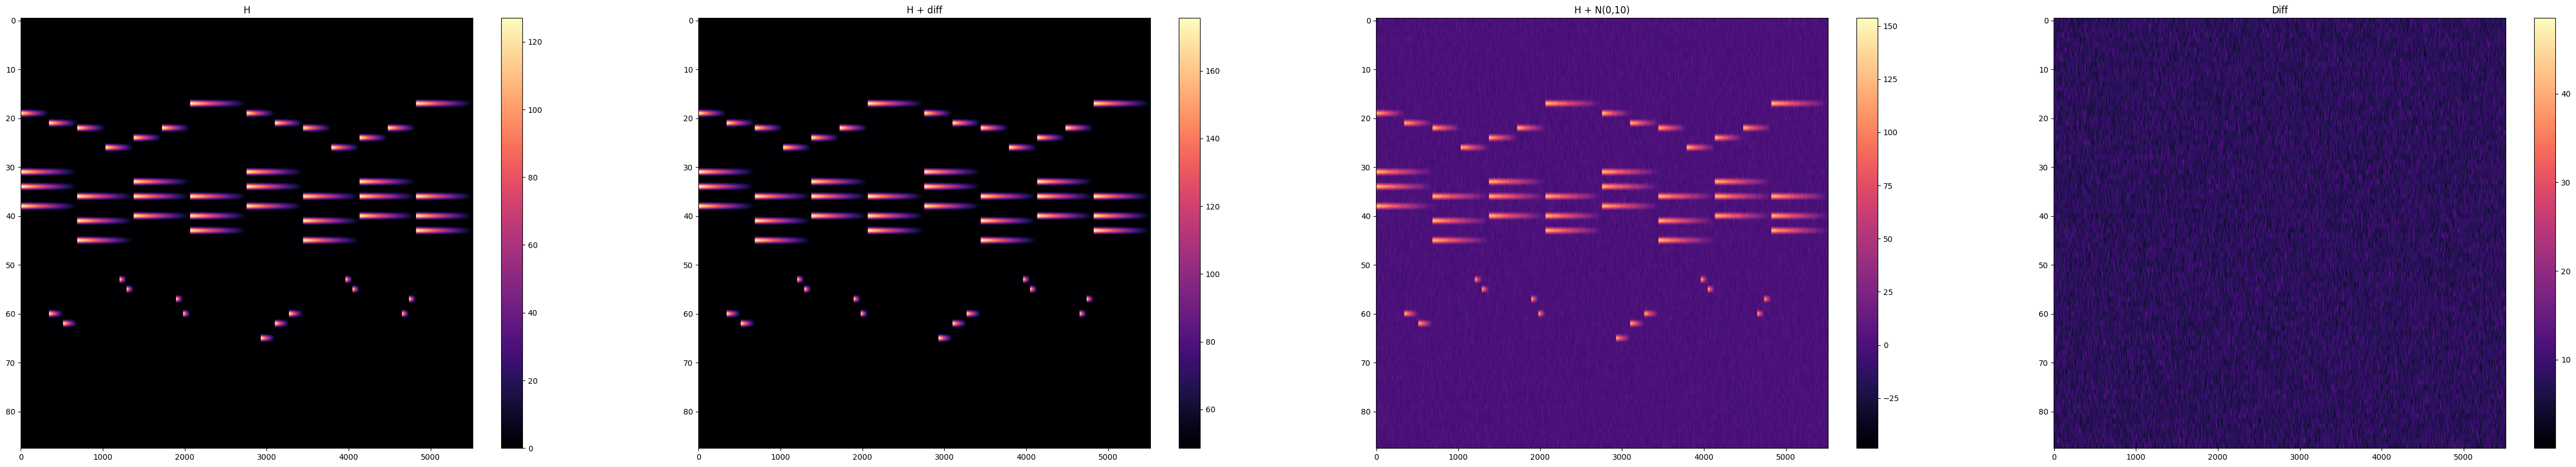

In [ ]:
sigma = 10
H_m = H + sigma*torch.randn(H.shape)
diff = torch.abs(H_m - H)
H_2 = H + diff.max()*torch.ones_like(H)

fig, ax = plt.subplots(1, 4, figsize=(60,10))

im1 = ax[0].imshow(H.cpu(),  aspect="auto", cmap='magma')
ax[0].set_title("H")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(H_2.cpu(),  aspect="auto", cmap='magma')
ax[1].set_title("H + diff")
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].imshow(H_m.cpu(),  aspect="auto", cmap='magma')
ax[2].set_title(f"H + N(0,{sigma})")
fig.colorbar(im3, ax=ax[2])

im4 = ax[3].imshow(diff.cpu(),  aspect="auto", cmap='magma')
ax[3].set_title("Diff")
fig.colorbar(im4, ax=ax[3])

In [ ]:
import mir_eval
def compute_metrics(prediction, ground_truth, time_tolerance=0.05, threshold=0):
    """
    Compute the precision, recall, F-measure and the accuracy of the transcription using mir_eval
    """
    if prediction == []:
        return 0, 0, 0, 0
    
    gt_notes = extract_note_events(ground_truth)
    pred_notes = extract_note_events(prediction, threshold=threshold)
    
    if len(gt_notes) == 0 or len(pred_notes) == 0:
        return 0, 0, 0, 0
    
    gt_times = gt_notes[:,0:2]
    gt_pitch = gt_notes[:,2]
    
    pred_times = pred_notes[:,0:2]
    pred_pitch = pred_notes[:,2]
    
    if np.any(gt_pitch < 21) or np.any(pred_pitch < 21):
        raise ValueError("Pitch values must be valid MIDI notes (21 <= X <= 108).")

    prec, rec, f_mes, _ = mir_eval.transcription.precision_recall_f1_overlap(
        gt_times, gt_pitch, pred_times, pred_pitch, 
        offset_ratio = None, onset_tolerance = time_tolerance, pitch_tolerance = 0.1)

    return prec, rec, f_mes, gt_notes, pred_notes

def extract_note_events(piano_roll, threshold=0):
    """
    Creates a note_event object from a piano_roll tensor
    The note_event is a list of notes (start, end, pitch)
    """
    # Pad the tensor to handle edge cases
    padded_tensor = torch.zeros(piano_roll.shape[0], piano_roll.shape[1] + 2, device=piano_roll.device)
    padded_tensor[:, 1:-1] = piano_roll

    note_events = []
    note_starts = ((padded_tensor[:, :-1] <= threshold) & (padded_tensor[:, 1:] > threshold)).nonzero(as_tuple=True)
    note_ends = ((padded_tensor[:, :-1] > threshold) & (padded_tensor[:, 1:] <= threshold)).nonzero(as_tuple=True)

    # Iterate over each pitch and pair starts with ends
    for pitch in range(padded_tensor.shape[0]):
        starts = note_starts[1][note_starts[0] == pitch]
        ends = note_ends[1][note_ends[0] == pitch]

        # Pair each start with an end
        for start, end in zip(starts, ends):
            note_events.append([start.item(), end.item(), pitch+21])

    return np.array(note_events, dtype=np.int32).reshape(-1, 3)

prec, rec, f, gt_notes, pred_notes = compute_metrics(H_m, H, threshold=diff.max())
print(prec, rec, f, len(gt_notes), len(pred_notes))

0.04717853839037928 1.0 0.0901060070671378 51 1081


In [ ]:
prec, rec, f, acc, gt_notes, pred_notes = utils.compute_metrics(H_m, H, threshold=diff.max())
print(prec, rec, f, acc, len(pred_notes), len(gt_notes))

0.3893129770992366 1.0 0.5604395604395604 1.0 131 51


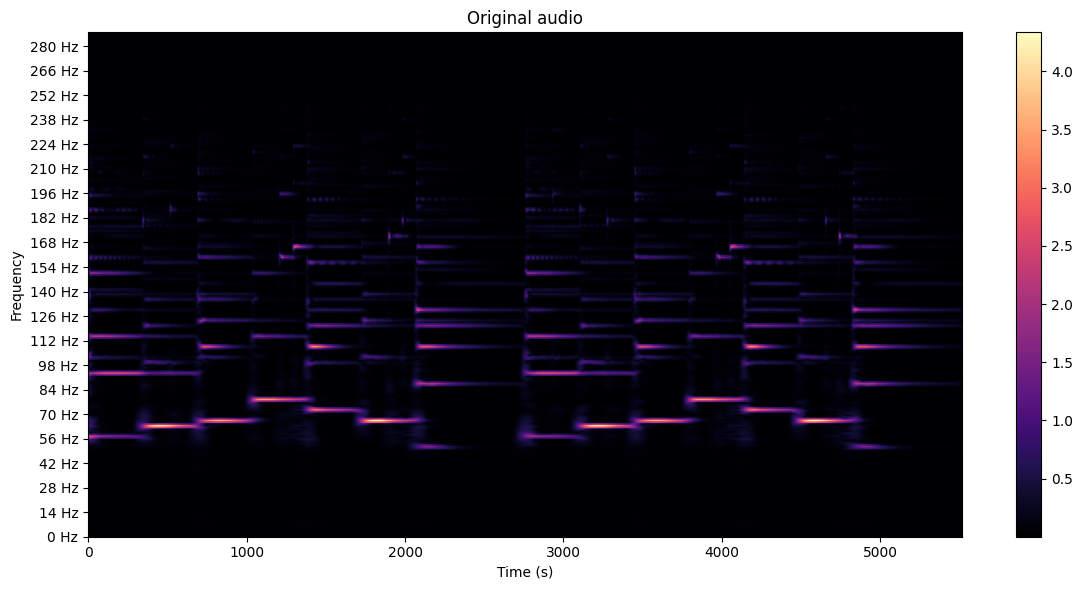

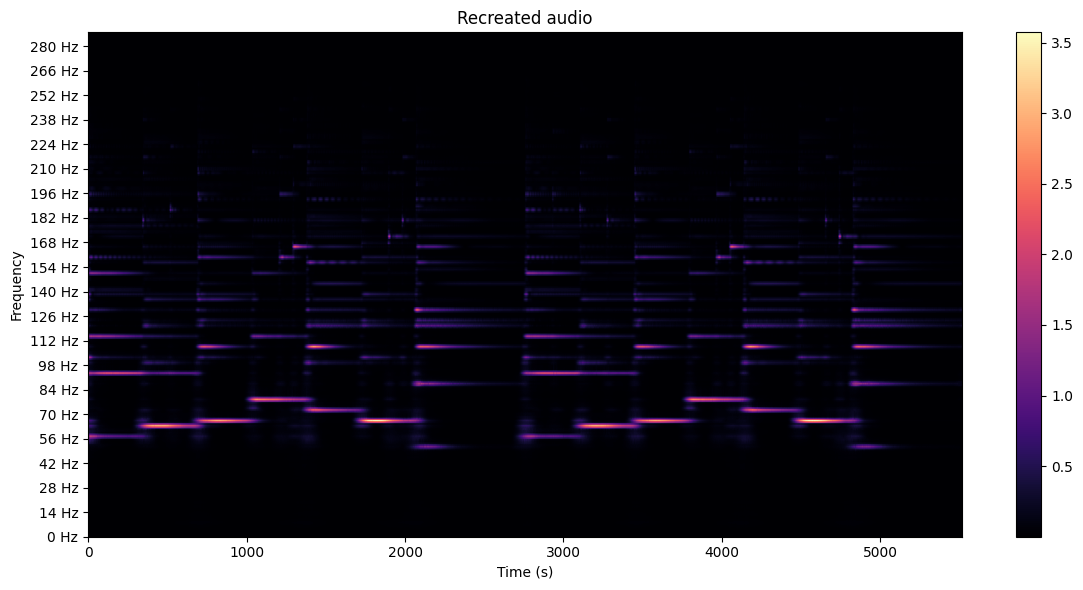

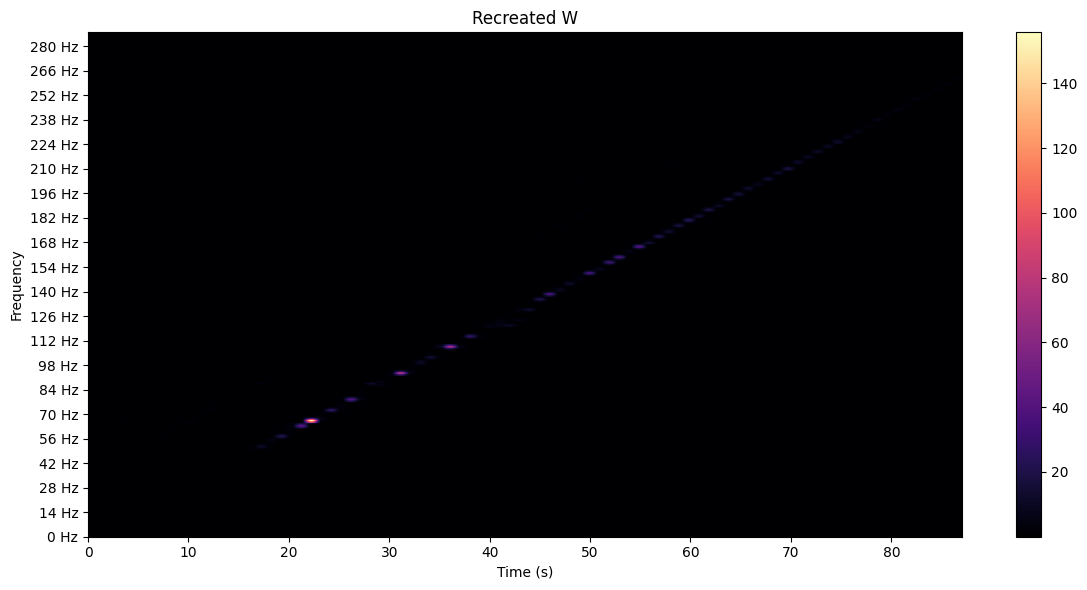

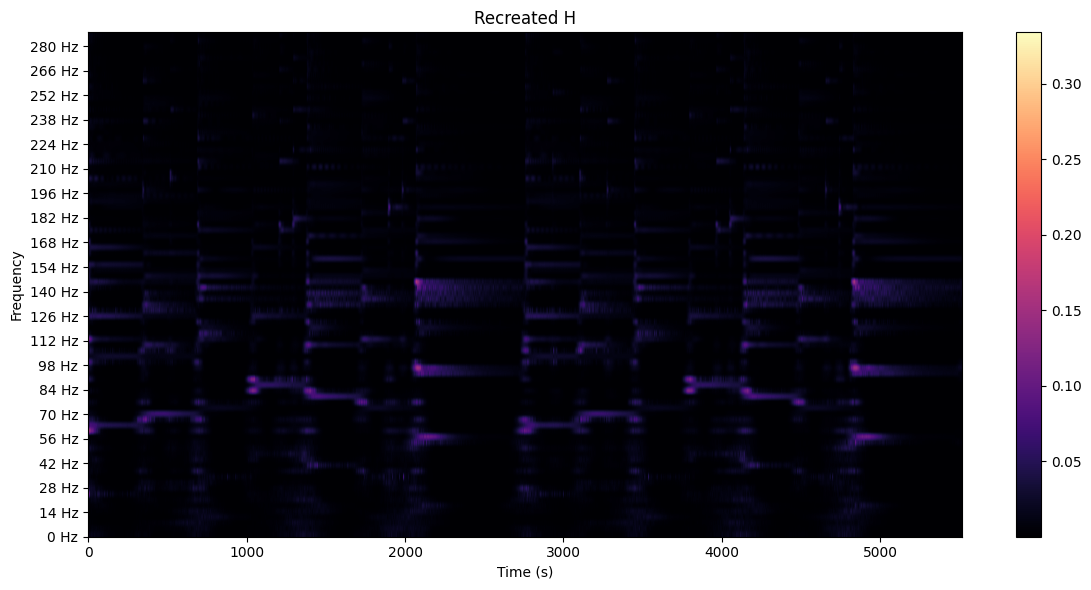

In [17]:
times = np.arange(M.shape[1])
freqs = np.arange(M.shape[0])

spec.vis_cqt_spectrogram(M.cpu(), times, freqs, 0, times[-1], title="Original audio")
spec.vis_cqt_spectrogram(M_hat.detach().cpu(), times, freqs, 0, times[-1], title="Recreated audio")
spec.vis_cqt_spectrogram(W_hat.detach().cpu(), np.arange(88), freqs, 0, 88, title="Recreated W")
spec.vis_cqt_spectrogram(H_hat.detach().cpu(), times, freqs, 0, times[-1], title="Recreated H")